# Link Colab with google drive

In [1]:
from src.run_experiment import Experiment, same_seeds
from models.autoencoder import AutoEncoder
from models.clustering import PhaseClassifier
from load_dataset.exhaust import *

# Make sure that you can always have updated modules/functions from other python files.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dataset preprocessing

## View the dataset
Load the .bcf file and create an object of `SEMDataset` (which uses hyperspy as backend.)

Something you can do with the `sem` object:
1. `sem.bse`: access the back-scattered electron image.

2. `sem.edx`: access the edx dataset.

3. `plot_sum_spectrum(sem.edx)`: view the sum spectrum (or use hyperspy built-in function `sem.edx.sum().plot(xray_lines=True)`).

4. `sem.feature_list`: view the default chosen elemental peaks in the edx dataset.

5. `sem.set_feature_list`: set new elemental peaks. 


In [2]:
#@markdown ### Enter a file path to load .bcf file:

# Load .bcf file
file_path = '/home/tung/Github/bcf_files/XLI_exhaust_011.bcf' #@param {type:"string"}
sem = SEMDataset(file_path)

<Signal2D, title: Ch 0, dimensions: (|739, 672)>
├── Acquisition_instrument
│   └── SEM
│       ├── beam_energy = 15.0
│       └── magnification = 10191.26669
├── General
│   ├── original_filename = XLI_exhaust_011.bcf
│   └── title = Ch 0
├── Sample
│   └── name = Undefinded
└── Signal
    ├── binned = False
    └── signal_type = 



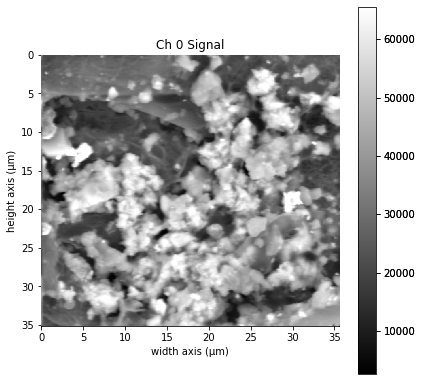

In [3]:
#@title Check metadata of the dataset { run: "auto" }

dataset = "bse" #@param ["edx", "bse"]

# Check edx dataset
if dataset == "edx":
    print(sem.edx)
    print(sem.edx.metadata)
elif dataset == "bse":
    print(sem.bse)
    print(sem.bse.metadata)
    sem.bse.plot()

In [4]:
# Or check the sum spectrum using an interactive plot function (written by me).
plot_sum_spectrum(sem.edx)

In [31]:
#@title Identify Energy Peak { run: "auto" }

# Find the peak which hasn't been identified
peak_energy_keV =   1.489#@param {type:"number"}

hs.eds.get_xray_lines_near_energy(energy=peak_energy_keV, only_lines=['a', 'b'])

['Al_Ka',
 'Br_La',
 'Tm_Mb',
 'Tm_Ma',
 'Yb_Ma',
 'Br_Lb1',
 'Er_Mb',
 'Se_Lb1',
 'Al_Kb',
 'Yb_Mb',
 'Er_Ma',
 'Lu_Ma',
 'Kr_La']

In [32]:
# Check the default elemental peaks
sem.feature_list

['Al_Ka', 'C_Ka', 'Ca_Ka', 'Cl_Ka', 'Cr_Ka', 'Fe_Ka', 'Mn_Ka', 'O_Ka', 'Si_Ka']

In [33]:
# Change the default elemental peaks
sem.set_feature_list(['O_Ka', 'Fe_Ka', 'Mg_Ka', 'Ca_Ka', 'Al_Ka', 'C_Ka', 'Si_Ka', 'S_Ka'])
plot_sum_spectrum(sem.edx)

Set feature_list as ['O_Ka', 'Fe_Ka', 'Mg_Ka', 'Ca_Ka', 'Al_Ka', 'C_Ka', 'Si_Ka', 'S_Ka']


## Process the dataset
Some useful functions:
1. `sem.rebin_signal(size=(2,2))`: rebin the edx signal with the size of 2x2. After rebinning the dataset, we can access the binned edx or bse data using `sem.edx_bin` or `sem.bse_bin`.

2. `peak_intensity_normalisation(sem.edx_bin)`: normalise the x-ray intensity along energy axis.

3. `remove_fist_peak`: remove the first x-ray peak by calling the function with the argument `end`.

4. `peak_denoising_PCA`: denoise the spectrum using *Principle Component Analysis (PCA)*.

    > `n_components_to_reconstruct`: specify how many components to reconstruct the the EDX intensity profile.

    > `spectrum.plot_results`: True to plot all results.

5. `plot_intensity_maps`: Plot the elemental intensity maps.

Rebinning the intensity with the size of (2, 2)
Before binning:


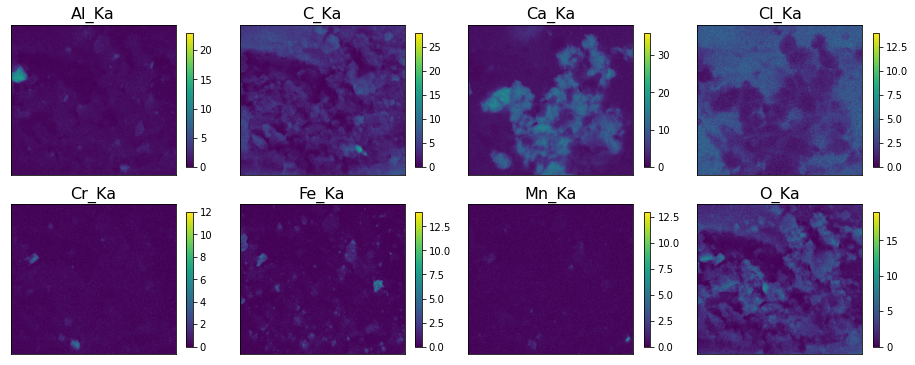

After binning:


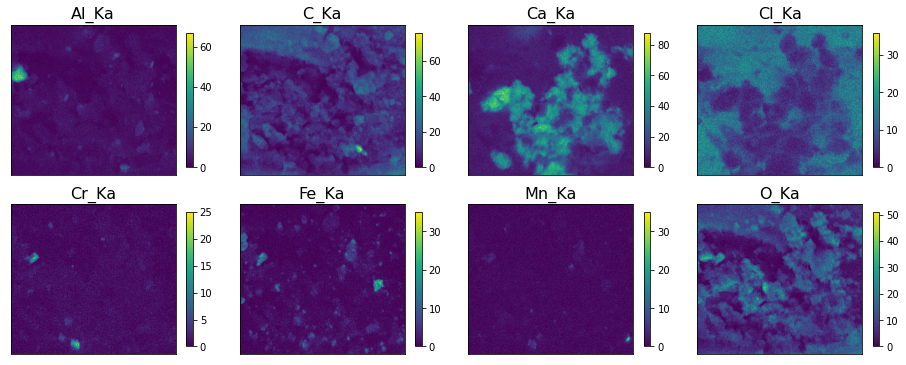

In [5]:
# Rebin both edx and bse dataset
sem.rebin_signal(size=(2,2))

print('Before binning:')
plot_intensity_maps(sem.edx, sem.feature_list)
print('After binning:')
plot_intensity_maps(sem.edx_bin, sem.feature_list)

In [6]:
# Normalisation along energy axis
peak_intensity_normalisation(sem.edx_bin)
plot_sum_spectrum(sem.edx_bin)

In [34]:
#@title Remove the first peak by seeting the end energy

# Remove the first peak
end_energy = 0.1197 #@param {type:"number"}

sem.remove_fist_peak(end=end_energy) 
plot_sum_spectrum(sem.edx_bin)

Removing the fisrt peak by setting the intensity to zero until the energy of 0.1197 keV.


In [35]:
# Denoise the X-ray profile using PCA.
peak_denoising_PCA(sem.edx_bin, n_components_to_reconstruct=10, plot_results=False)

Decomposition info:
  normalize_poissonian_noise=True
  algorithm=SVD
  output_dimension=10
  centre=None


<EDSSEMSpectrum, title: EDX, dimensions: (369, 336|1595)>

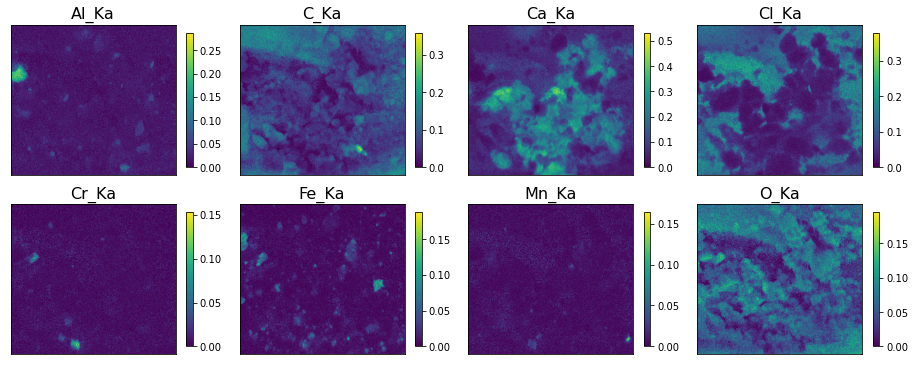

In [ ]:
# Plot elemental intensity map
plot_intensity_maps(sem.edx_bin, sem.feature_list, grid_dims=(2,4))

## Normalisation

Set feature_list as ['O_Ka', 'Fe_Ka', 'Mg_Ka', 'Ca_Ka', 'Al_Ka', 'C_Ka', 'Si_Ka', 'S_Ka']


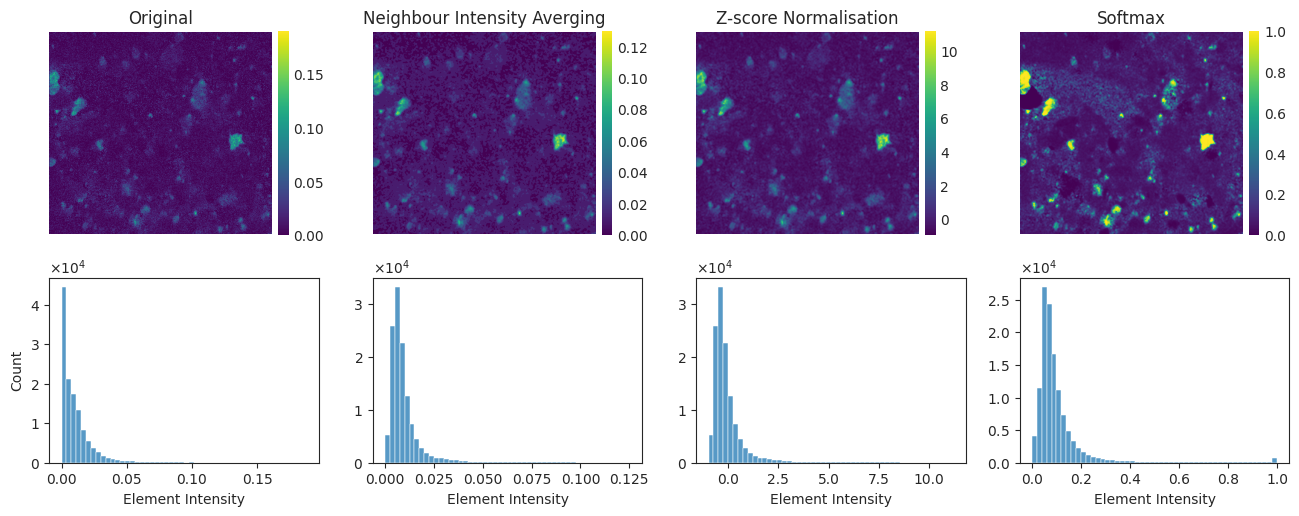

In [36]:
# Get a np.array from the object <sem>, size of dataset should be [336, 369, 8 (num_elements)]
feature_list = ['O_Ka', 'Fe_Ka', 'Mg_Ka', 'Ca_Ka', 'Al_Ka', 'C_Ka', 'Si_Ka', 'S_Ka']
dataset = sem.get_feature_maps(feature_list)

# Process the dataset by averaging the neighboring intensity
dataset_processed = avgerage_neighboring_signal(dataset)

# Apply z-score normalisation on each intensity map
dataset_norm = z_score_normalisation(dataset_processed)

# Apply softmax along the axis=2 
dataset_softmax = softmax(dataset_norm)

# Plot intensity distributions after (1)avgerage_neighboring_signal; (2)z_score_normalisation; (3) softmax
plot_pixel_distributions(sem, peak='Fe_Ka')

# Autoencoder

## Initialise experiment / model

In [48]:
# Fix the random seed, so that we can reproduce the training if using the same seed.
same_seeds(1)

# Set up the experiment, e.g. determining the model structure, dataset for training etc.
general_results_dir='results' 
EX = Experiment(descriptor='AE_unmix',
                general_results_dir=general_results_dir,
                model=AutoEncoder,
                model_args={'hidden_layer_sizes':(512,256,128)}, # number of hidden layers and corresponding neurons
                chosen_dataset=dataset_softmax,
                save_model_every_epoch=False)

model_name: Model-AE_unmix
size_dataset: (336, 369, 8)
device: cuda
num_parameters: 341770


## Training

In [ ]:
# Train the model (Can skip if you want to load the trained model parameters)
EX.run_model(num_epochs=50,
             patience=50, 
             batch_size=64,
             learning_rate=1e-4, 
             weight_decay=0.0, 
             task='train_all', # Change to 'train_all' to train all the dataset without separate some parts for evaluation
             noise_added=0.0,
             lr_scheduler_args={'factor':0.5,
                                'patience':5, 
                                'threshold':1e-2, 
                                'min_lr':1e-7,
                                'verbose':True}) 

## Loading model

In [49]:
# Load the trained model file 
EX.load_trained_model('/content/unmix/results/Model-AE_unmix_best')

# Get the dimension-reduced dataset
latent = EX.get_latent()

Loading model parameters from /content/unmix/results/Model-AE_unmix_best


# Gaussian mixture clustering

In [232]:
# Set up an object for GM clustering
PC = PhaseClassifier(latent, 
                     dataset_softmax, 
                     sem, 
                     method='BayesianGaussianMixture', 
                     method_args={'n_components':15, 'random_state':4, 'init_params':'kmeans'})

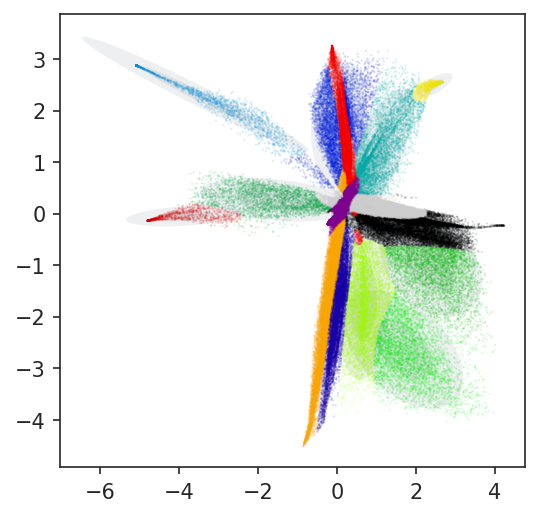

In [14]:
# Plot latent sapce (2-dimensional) with corresponding Gaussian models
PC.plot_latent_space()

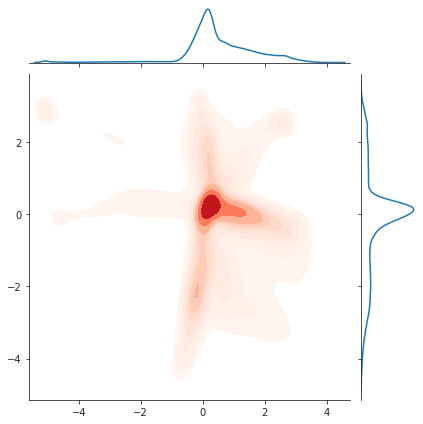

In [53]:
# library & dataset
import seaborn as sns
import matplotlib.pyplot as plt
 
# Custom the inside plot: options are: “scatter” | “reg” | “resid” | “kde” | “hex”
sns.jointplot(x=latent[:,0], y=latent[:,1], kind='kde',cmap="Reds", shade=True)
plt.show()

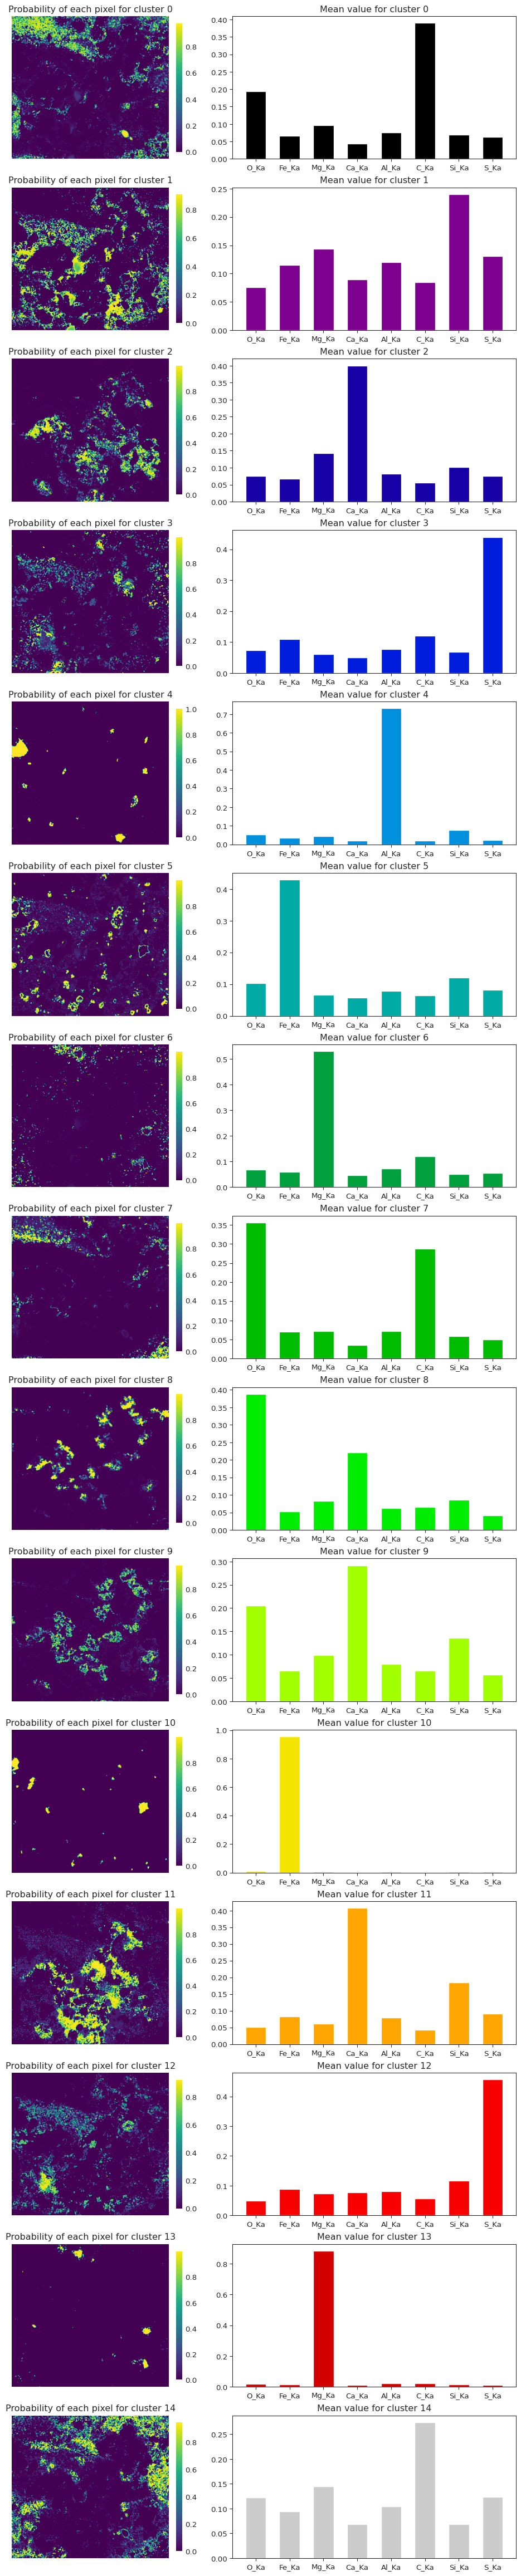

In [54]:
# Plot probability of each pixel for each cluster
PC.plot_phase_distribution()

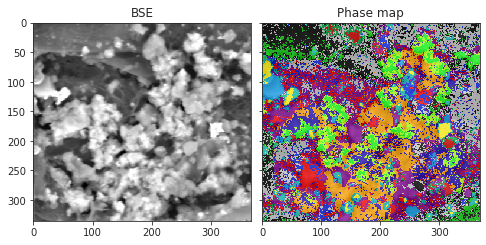

In [17]:
# Plot phase map using the corresponding GM model
PC.plot_phase_map()

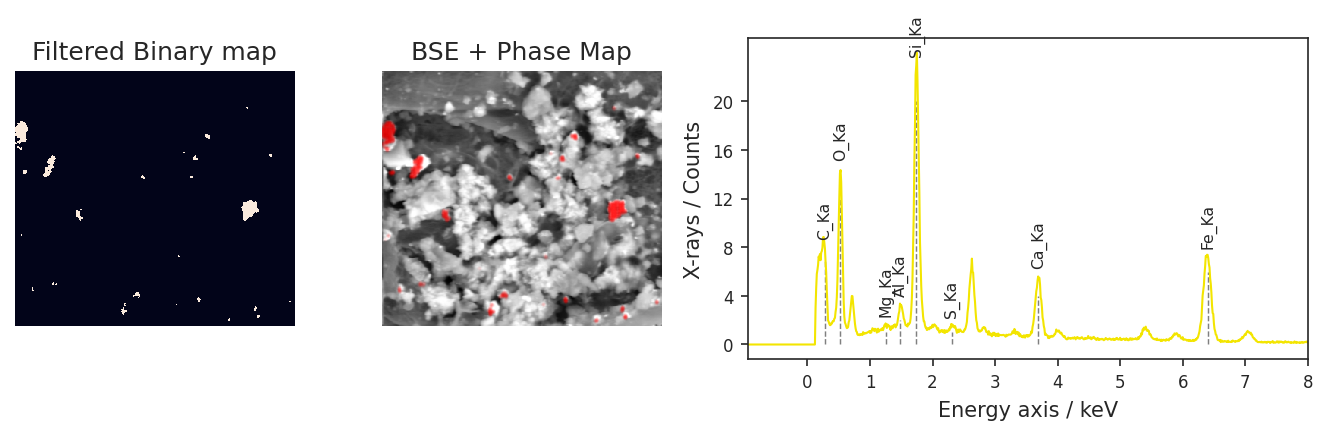

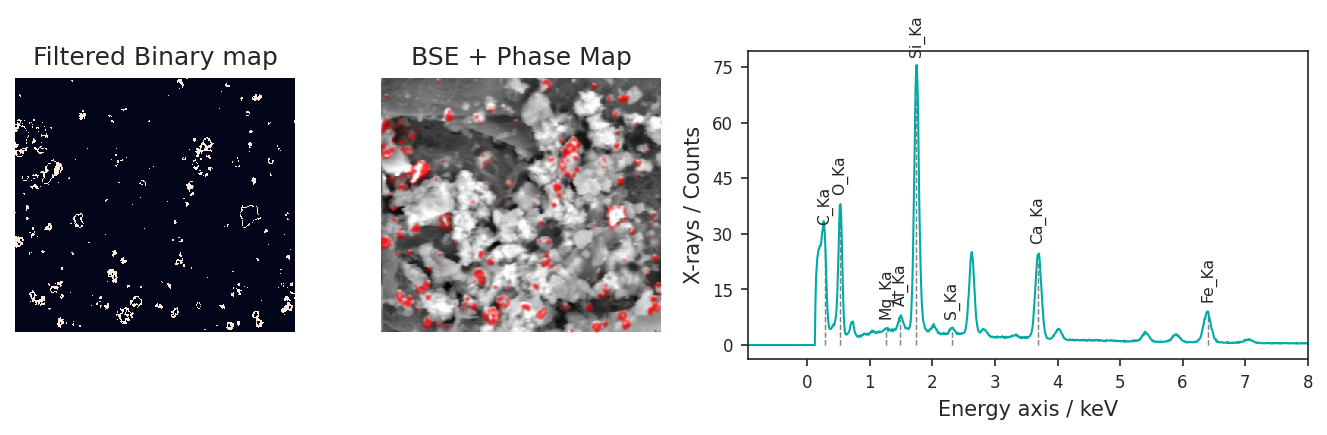

In [55]:
# Given a cluster, plot the binary map and the x-ray profile 
# from the corresponding pixels in the binary map.
binary_filter_args={'threshold':0.9, 
                    'denoise':False, 
                    'keep_fraction':0.13, 
                    'binary_filter_threshold':0.5}

PC.plot_binary_map_edx_profile(cluster_num=10, binary_filter_args=binary_filter_args)

PC.plot_binary_map_edx_profile(cluster_num=5, binary_filter_args=binary_filter_args)

In [ ]:
Fe_particle_edx = PC.get_masked_edx(cluster_num=10, binary_filter_args=binary_filter_args)
plot_sum_spectrum(Fe_particle_edx)

## Statistics of phase properties

In [ ]:
# Given a cluster, output a pandas dataframe containing statistical information
stat_info = PC.phase_statics(cluster_num=10,
                             element_peaks=['Fe_Ka', 'O_Ka'],
                             binary_filter_args={'threshold':0.9,
                                                 'denoise':False, 
                                                 'keep_fraction':0.13, 
                                                 'binary_filter_threshold':0.5})

# <stat_info> can be saved to .csv file
stat_info.to_csv('stat_info_Fe_particles.csv')
stat_info.head()

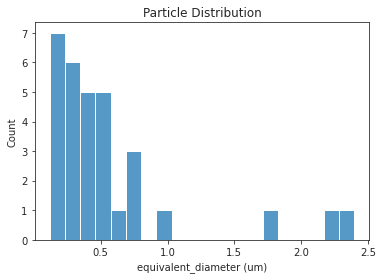

In [ ]:
# or can direct plot distributions.
sns.set_style('ticks')
sns.histplot(stat_info['equivalent_diameter (um)'],bins=20)
plt.title('Particle Distribution')
plt.show()

# Unmix x-ray profiles

In [99]:
weights, components = PC.get_unmixed_edx_profile(clusters_to_be_calculated=[0,1,3,5,10,12,14],
                                    normalised=True, method='NMF', 
                                    method_args={'init':'nndsvd'},
                                    binary_filter_args=binary_filter_args)

In [61]:
PC.sem.feature_list

['O_Ka', 'Fe_Ka', 'Mg_Ka', 'Ca_Ka', 'Al_Ka', 'C_Ka', 'Si_Ka', 'S_Ka']

In [91]:
import ipywidgets as widgets
from IPython.display import display

ALL = 'ALL'
def unique_sorted_values_plus_ALL(array):
    unique = array.unique().tolist()
    unique.sort()
    unique.insert(0, ALL)
    return unique

def plot_profile(cluster_num:int, component_num:int, feature_list:list):
    weight = W[cluster_num,component_num]
    profile=H[component_num,:]

    fig = go.Figure(data=go.Scatter(x=PC.energy_axis, y=profile),
                        layout_xaxis_range=[0,8],
                        layout=go.Layout(title="",
                                        title_x=0.5,
                                        xaxis_title="Energy / keV",
                                        yaxis_title="Intensity",
                                        width=900,
                                        height=500))
    zero_energy_idx = np.where(np.array(PC.energy_axis).round(2)==0)[0][0]
    for el in feature_list:
        peak = profile[zero_energy_idx:][int(peak_dict[el]*100)+1]
        fig.add_shape(type="line",
                    x0=peak_dict[el], y0=0, x1=peak_dict[el], y1=0.9*peak,
                    line=dict(color="black",
                                width=2,
                                dash="dot")
                        )

        fig.add_annotation(x=peak_dict[el], y=peak,
                            text=el,
                            showarrow=False,
                            arrowhead=2,
                            yshift=30,
                            textangle=270
                            )  
    fig.update_layout(showlegend=False)
    fig.update_layout(template='simple_white')
    fig.show()

In [148]:
dropdown_cluster = widgets.Dropdown(options=unique_sorted_values_plus_ALL(weights.index))
output_cluster = widgets.Output()
plots_output = widgets.Output()

def dropdown_cluster_eventhandler(change):
    output_cluster.clear_output()
    with output_cluster:
        if (change.new == ALL):
            display(weights)
        else:
            display(weights[weights.index == change.new])

    plots_output.clear_output()
    with plots_output:
        if (change.new != ALL):
            num_cpnt = len(weights.columns.to_list())
            fig, axs = plt.subplots(1,1,figsize=(4,3),dpi=96)
            axs.bar(np.arange(0,num_cpnt), weights[weights.index == change.new].to_numpy().ravel(), width=0.6)
            axs.set_xticks(np.arange(0,num_cpnt))
            axs.set_ylabel('weight of component')
            axs.set_xlabel('component number')
            plt.show()

dropdown_cluster.observe(dropdown_cluster_eventhandler, names='value')

display(dropdown_cluster)
display(output_cluster)
display(plots_output)

Dropdown(options=('ALL', 'cluster_0', 'cluster_1', 'cluster_10', 'cluster_12', 'cluster_14', 'cluster_3', 'clu…

Output()

Output()

In [ ]:
#@title Identify Energy Peak { run: "auto" }

# Find the peak which hasn't been identified
peak_energy_keV =   1.489#@param {type:"number"}

hs.eds.get_xray_lines_near_energy(energy=peak_energy_keV, only_lines=['a', 'b'])

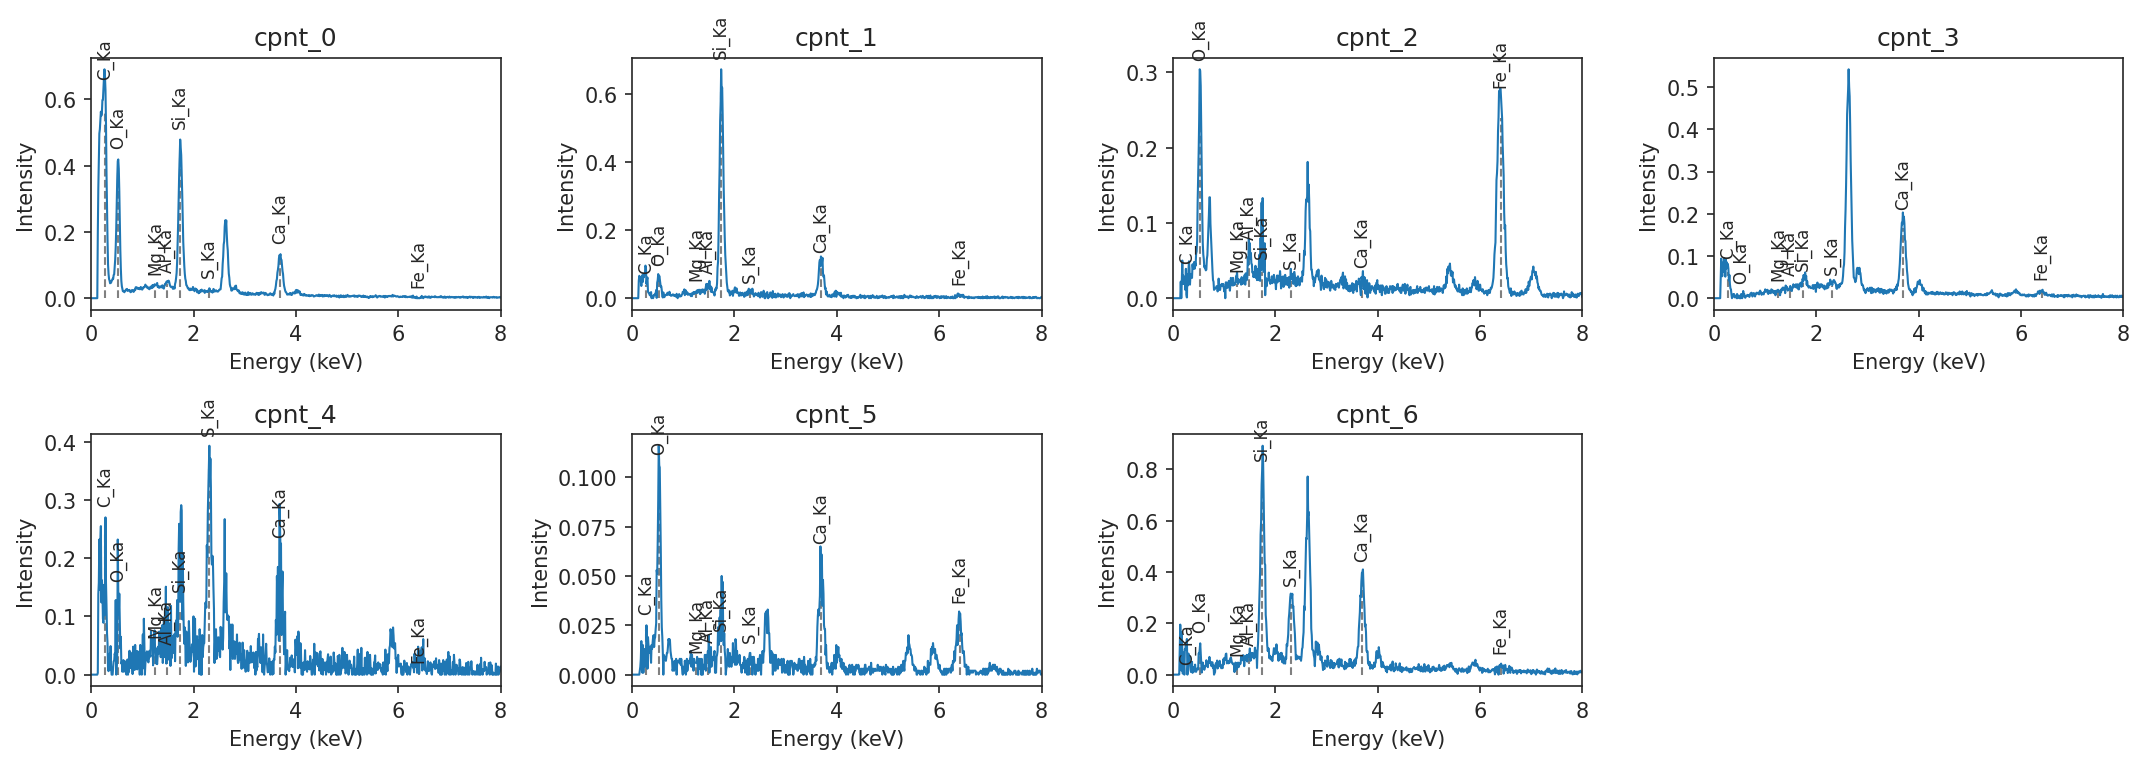

In [235]:
sem.feature_list.extend([])
PC.plot_unmixed_profile(weights, components, peak_list=[])

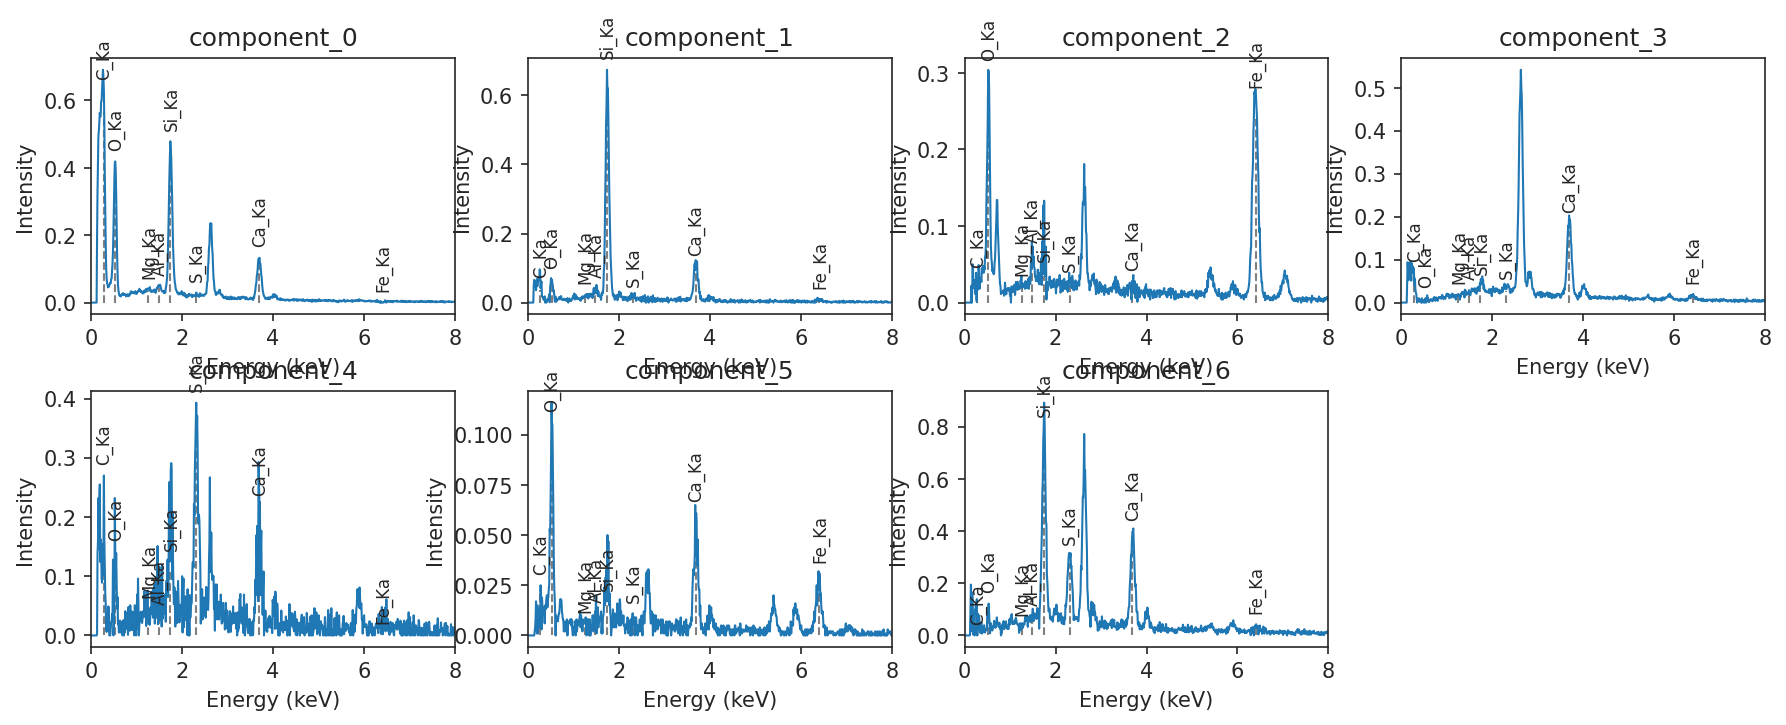

In [240]:
peak_list = PC.peak_list
def plot_unmixed_profile(weights, components, peak_list = PC.peak_list):
    cpnt_num = len(weights.columns.to_list())
    if cpnt_num > 4:
        n_rows = 2
        n_cols = (cpnt_num//2) +1
    else:
        n_rows = 1
        n_cols = cpnt_num

    fig, axs = plt.subplots(n_rows, n_cols,figsize=(n_cols*3.6, n_rows*2.6),dpi=150)
    for row in range(n_rows):
        for col in range(n_cols):
            cur_cpnt = (row*n_cols)+col
            if (row==1) and (cpnt_num%2==1) and (cur_cpnt==7): # delete the extra subfigures
                fig.delaxes(axs[row,col]) 
                break
            cpnt = f'cpnt_{cur_cpnt}'
            axs[row,col].plot(PC.energy_axis, components[cpnt], linewidth=1)
            axs[row,col].set_xlim(0,8)
            axs[row,col].set_ylabel('Intensity')
            axs[row,col].set_xlabel('Energy (keV)')
            axs[row,col].set_title(f'component_{cur_cpnt}')

            zero_energy_idx = np.where(np.array(PC.energy_axis).round(2)==0)[0][0]
            intensity = components[cpnt].to_numpy()
            for el in PC.peak_list:
                peak = intensity[zero_energy_idx:][int(PC.peak_dict[el]*100)+1]
                axs[row,col].vlines(PC.peak_dict[el], 0, 0.9*peak, linewidth=1, color = 'grey', linestyles='dashed')
                axs[row,col].text(PC.peak_dict[el]-0.18, peak+(intensity.max()/15), el, rotation='vertical', fontsize=8)
        
    fig.subplots_adjust(hspace=0.3, wspace=0.2)
    plt.show()

plot_unmixed_profile(weights, components)